In [263]:
import json
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [264]:
%config InlineBackend.figure_formats = ['svg']

In [265]:
df = pd.read_json('data/isoflops_curves.json')

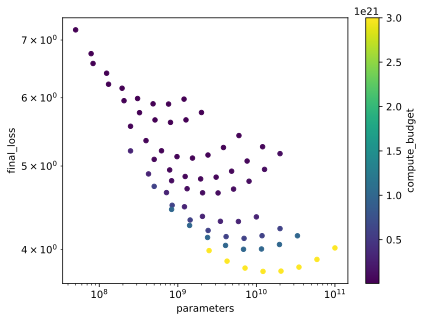

In [266]:
df.plot.scatter(x='parameters', y='final_loss', c='compute_budget', logx=True, logy=True)
plt.show()

a=0.208036928676953, b=-8.415530499478733, c=90.99338950143232
[608221483.8116884] 5.886920618652468
a=0.1867029680044828, b=-7.6551681897422705, c=84.08361456559406
[608221483.8116884, 800644790.1731429] 5.614588818993582
a=0.15164436851834598, b=-6.389569752126961, c=72.41161152841985
[608221483.8116884, 800644790.1731429, 1411068481.6932886] 5.105120004541433
a=0.13538990830921024, b=-5.800284879159572, c=66.95175129755522
[608221483.8116884, 800644790.1731429, 1411068481.6932886, 2008530515.7419648] 4.828759452086736
a=0.12563840895692338, b=-5.448996217781126, c=63.726196230967176
[608221483.8116884, 800644790.1731429, 1411068481.6932886, 2008530515.7419648, 2616837848.777422] 4.644821299728754
a=0.10747413871719723, b=-4.777814170924348, c=57.40097122921272
[608221483.8116884, 800644790.1731429, 1411068481.6932886, 2008530515.7419648, 2616837848.777422, 4501780496.754634] 4.30096846493651
a=0.092440620328393, b=-4.179327223124518, c=51.35589317946927
[608221483.8116884, 800644790

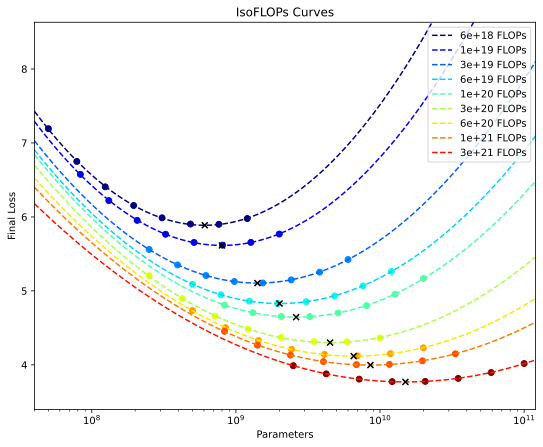

In [270]:

# Fit a parabola to each of the isoflop curves
isoflop_dfs = [df[df['compute_budget'] == b] for b in df['compute_budget'].unique()]
isoflop_curves = [
    curve_fit(lambda x, a, b, c: a*x**2 + b*x + c, np.log(isoflop_df['parameters']), isoflop_df['final_loss'])
    for isoflop_df in isoflop_dfs
]

c_min = df['compute_budget'].min()
c_max = df['compute_budget'].max()

opt_params = []
for i, (curve, isoflop_df) in enumerate(zip(isoflop_curves, isoflop_dfs)):
    a, b, c = curve[0]
    xs = np.linspace(np.log(df['parameters'].min() * 0.8), np.log(df['parameters'].max() * 1.2), 200)
    ys = a*xs**2 + b*xs + c
    plt.plot(np.exp(xs), ys, label=f'{isoflop_df["compute_budget"].iloc[0]:.0e} FLOPs', c=plt.cm.jet(i / len(isoflop_curves)), linestyle='--')
    print(f'{a=}, {b=}, {c=}')
    opt_params.append(np.exp(-b / (2 * a)))
    plt.scatter(opt_params[-1], c - b**2 / (4 * a), c='black', marker='x', zorder=5)
    print(opt_params, c - b**2 / (4 * a))

opt_params = np.array(opt_params)

plt.legend(loc='upper right')
plt.scatter(df['parameters'], df['final_loss'], c=np.log(df['compute_budget']), cmap='jet')
ax = plt.gca()
ax.set_xlim(df['parameters'].min() * 0.8, df['parameters'].max() * 1.2)
ax.set_ylim(df['final_loss'].min() * 0.9, df['final_loss'].max() * 1.2)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.title('IsoFLOPs Curves')
plt.xlabel('Parameters')
plt.ylabel('Final Loss')
plt.gcf().set_size_inches(9, 7)
plt.show()

a=0.5145794847849271 b=-2.0161390296611112
[1.e+23 1.e+24] [9.11444219e+10 2.98064037e+11]


(267656451.2910312, 425807630326.729)

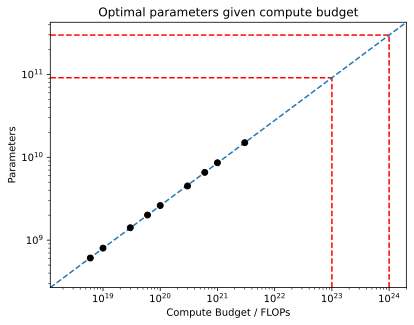

In [271]:
compute_budgets = df['compute_budget'].unique()
fit_params = curve_fit(lambda x, a, b: a * np.log(x) + b, compute_budgets, np.log(opt_params))
a, b = fit_params[0]
# xs = np.linspace(c_min * 0.2, c_max * 5, 200)
xs = np.linspace(c_min * 0.2, 2 * 10.0**24, 200)
ys = a * np.log(xs) + b

print(f"{a=} {b=}")

plt.plot(xs, np.exp(ys), label=f'Fit: {np.exp(b):.2f} * x^{np.exp(a):.2f}', linestyle='--', zorder=1)
plt.scatter(compute_budgets, opt_params, c='black')
plt.xscale('log')
plt.yscale('log')
plt.title('Optimal parameters given compute budget')
plt.xlabel('Compute Budget / FLOPs')
plt.ylabel('Parameters')

ext_compute = np.array([10.0**23, 10.0**24])
ext_projected = np.exp(a * np.log(ext_compute) + b)
print(ext_compute, ext_projected)
plt.vlines(ext_compute, np.exp(ys).min(), ext_projected, linestyle='--', color='red', zorder=0)
plt.hlines(ext_projected, xs.min(), ext_compute, linestyle='--', color='red', zorder=0)
plt.xlim(xs.min(), ext_compute.max() * 2)
plt.ylim(np.exp(ys).min(), np.exp(ys.max()))

[1.e+23 1.e+24] [1.82859975e+11 5.59163958e+11]


(267656451.2910312, 782826115815.6356)

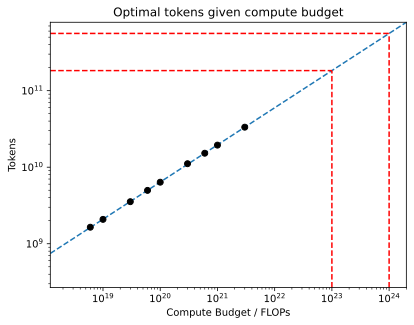

In [272]:
plt.scatter(compute_budgets, compute_budgets / (6 * opt_params), c='black')
ys_tok = xs / (6 * np.exp(ys))
plt.plot(xs, ys_tok, label='6 * flops / exp(ys)', linestyle='--', zorder=-5)
plt.xscale('log')
plt.yscale('log')
plt.title('Optimal tokens given compute budget')
plt.xlabel('Compute Budget / FLOPs')
plt.ylabel('Tokens')
ext_projected_tok = ext_compute / (6 * np.exp(a * np.log(ext_compute) + b))
print(ext_compute, ext_projected_tok)
plt.vlines(ext_compute, np.exp(ys).min(), ext_projected_tok, linestyle='--', color='red', zorder=0)
plt.hlines(ext_projected_tok, xs.min(), ext_compute, linestyle='--', color='red', zorder=0)
plt.xlim(xs.min(), ext_compute.max() * 2)
plt.ylim(np.exp(ys).min(), ys_tok.max())

Compute budget $ C = 6 \cdot N \cdot D $ with 

In [6]:
# Compute budget:
# C = 6 * N * D


In [273]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
from cs336_scaling.scaling import get_previous_runs 

In [277]:
df = get_previous_runs()
df.rename(columns={'train_flops': 'compute_budget', 'loss': 'final_loss'}, inplace=True)
df['parameters'] = 12 * df['num_layers'] * df['d_model'] ** 2
# drop row 0
df = df.drop(0)
df.sort_values('final_loss', inplace=True)
df[:10]

,final_loss,total_flops_used,d_model,num_layers,num_heads,batch_size,learning_rate,compute_budget,parameters
83,5.424976,731350000000000000,224,7,7,128,0.0001,100000000000000000,4214784
82,5.448756,631350000000000000,320,10,10,128,0.0001,100000000000000000,12288000
84,5.495541,831350000000000000,192,6,6,128,0.0001,100000000000000000,2654208
77,5.519215,131350000000000000,384,12,12,128,0.0001,100000000000000000,21233664
78,5.646725,231350000000000000,480,15,15,128,0.0001,100000000000000000,41472000
79,5.757307,331350000000000000,576,18,12,128,0.0001,100000000000000000,71663616
80,5.759573,431350000000000000,576,18,16,128,0.0001,100000000000000000,71663616
81,5.814377,531350000000000000,640,20,16,128,0.0001,100000000000000000,98304000
93,6.160831,881950000000000000,128,4,4,128,0.0001,30000000000000000,786432
97,6.166139,1001950000000000000,160,5,5,128,0.0001,30000000000000000,1536000


7


[0     18874368
 1     11796480
 2      7864320
 3     30081024
 4     47185920
 5      5308416
 6     44040192
 7     14155776
 8     49152000
 9      1572864
 10    31457280
 11    49545216
 12    38535168
 13     6291456
 14     3932160
 15     3932160
 16    37748736
 17     3538944
 18    11010048
 19    12582912
 20    28311552
 21    37158912
 22    10223616
 23    39321600
 24    28901376
 25    14155776
 26     4718592
 27     1572864
 28     8650752
 29    21233664
 30     5505024
 31     7077888
 32    28311552
 33    25165824
 34    24772608
 35     3538944
 36    15728640
 37    19464192
 38     1572864
 39    40894464
 40    19660800
 41     9830400
 42    17301504
 43    10616832
 44    42467328
 45    29491200
 46    14155776
 47    35389440
 48    15925248
 49    21233664
 50     2359296
 51    22020096
 52     2359296
 53    15728640
 54    17694720
 55     3145728
 56    19267584
 Name: parameters, dtype: int64,
 0    4214784
 1    2654208
 2    1536000
 Name: parame

[0     10.538349
 1     10.541352
 2     10.546355
 3     10.542446
 4     10.539880
 5     10.538969
 6     10.539988
 7     10.540134
 8     10.540117
 9     10.546935
 10    10.541286
 11    10.541040
 12    10.540649
 13    10.540337
 14    10.541629
 15    10.541629
 16    10.539988
 17    10.542149
 18    10.542354
 19    10.539716
 20    10.539548
 21    10.539094
 22    10.542354
 23    10.542222
 24    10.542568
 25    10.542883
 26    10.541412
 27    10.546935
 28    10.542354
 29    10.545624
 30    10.544377
 31    10.544232
 32    10.550599
 33    10.531537
 34    10.546979
 35    10.530228
 36    10.542840
 37    10.543259
 38    10.543203
 39    10.545082
 40    10.544092
 41    10.544091
 42    10.543750
 43    10.543289
 44    10.544492
 45    10.544395
 46    10.543152
 47    10.544502
 48    10.544644
 49    10.544819
 50    10.535959
 51    10.535321
 52    10.533447
 53    10.544719
 54    10.544630
 55    10.517449
 56    10.537604
 Name: final_loss, dtype: float

a=-0.00023396333622303589 b=0.008437840362905227
a=0.11744496904131511 b=-3.4072046932969893
a=0.027154167896078746 b=-0.5683496860549752
a=0.09491191481635974 b=-2.363254656555132
a=0.03742940430665832 b=-1.0471794371532357
a=-0.0027443549090976215 b=0.10077098108357174
a=0.05262124754458611 b=-1.6469933286388938


/var/folders/bd/847y_93d4tl6nwdgxdzs7lgm0000gn/T/ipykernel_79719/4176382033.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  curve_fit(lambda x, a, b, c: a*x**2 + b*x + c, np.log(isoflop_df['parameters']),isoflop_df['final_loss'])


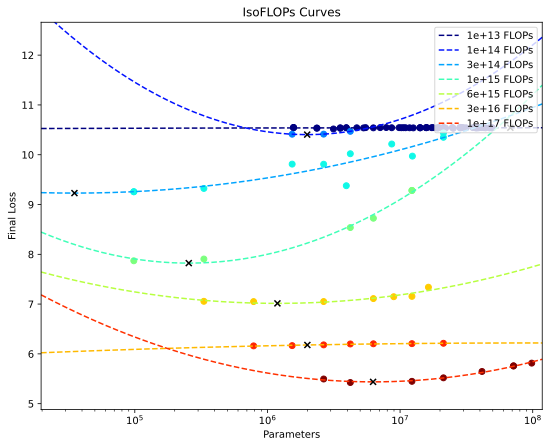

In [300]:
# Fit a parabola to each of the isoflop curves
df.sort_values('compute_budget', inplace=True)
isoflop_dfs = [df[df['compute_budget'] == b].reset_index() for b in df['compute_budget'].unique()]
print(len(isoflop_dfs))
display([idf['parameters'] for idf in isoflop_dfs])
display([idf['final_loss'] for idf in isoflop_dfs])
isoflop_curves = [
    curve_fit(lambda x, a, b, c: a*x**2 + b*x + c, np.log(isoflop_df['parameters']),isoflop_df['final_loss'])
    for isoflop_df in isoflop_dfs
]

c_min = df['compute_budget'].min()
c_max = df['compute_budget'].max()

opt_params = []
opt_vals = []
xs = np.linspace(np.log(df['parameters'].min() * 0.2), np.log(df['parameters'].max() * 1.2), 200)
for i, (curve, isoflop_df) in enumerate(zip(isoflop_curves, isoflop_dfs)):
    a, b, c = curve[0]
    ys = a*xs**2 + b*xs + c
    plt.plot(np.exp(xs), ys, label=f'{isoflop_df["compute_budget"].iloc[0]:.0e} FLOPs', c=plt.cm.jet(i / len(isoflop_curves)), linestyle='--')
    if (isoflop_df['compute_budget'].iloc[0] == 30000000000000000):
        opt_params.append(2e6)
    else:
        opt_params.append(np.exp(-b / (2 * a)))
    print(f'{a=} {b=}')
    logoptparam = np.log(opt_params[-1])
    opt_val = a * logoptparam ** 2 + b * logoptparam + c
    opt_vals.append(opt_val)
    plt.scatter(opt_params[-1], opt_val, c='black', marker='x', zorder=5)

compute_budgets = np.array(df['compute_budget'].unique())
opt_params = np.array(opt_params)
opt_vals = np.array(opt_vals)

plt.legend(loc='upper right')
plt.scatter(df['parameters'], df['final_loss'], c=np.log(df['compute_budget']), cmap='jet')
ax = plt.gca()
ax.set_xlim(df['parameters'].min() * 0.2, df['parameters'].max() * 1.2)
ax.set_ylim(df['final_loss'].min() * 0.9, df['final_loss'].max() * 1.2)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.title('IsoFLOPs Curves')
plt.xlabel('Parameters')
plt.ylabel('Final Loss')
plt.gcf().set_size_inches(9, 7)
plt.show()

Optimal loss at 1e19 FLOPs: 3.5908059943332646


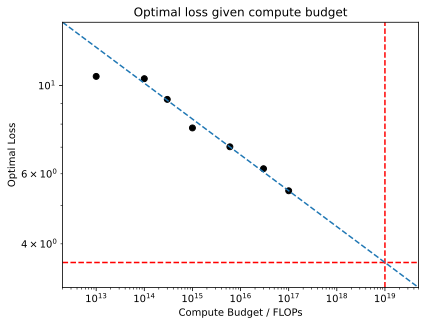

In [317]:
# Plot opt loss predictions
plt.scatter(compute_budgets, opt_vals, c='black')
plt.xscale('log')
plt.yscale('log')
# Fit in log-log
a, b = curve_fit(lambda x, a, b: a * x + b, np.log(compute_budgets[1:]), np.log(opt_vals[1:]))[0]
extrapolate_x = np.geomspace(compute_budgets.min() * 0.2, 5e19, 200)
extrapolate_loss = np.exp(a * np.log(extrapolate_x) + b)
plt.plot(extrapolate_x, extrapolate_loss, label=f'Fit: {np.exp(b):.2f} * x^{np.exp(a):.2f}', linestyle='--', zorder=1)
plt.title('Optimal loss given compute budget')
plt.xlabel('Compute Budget / FLOPs')
plt.ylabel('Optimal Loss')
plt.vlines(1e19, extrapolate_loss.min(), extrapolate_loss.max(), linestyle='--', color='red', zorder=0)
plt.hlines(np.exp(a * np.log(1e19) + b), extrapolate_x.min(), extrapolate_x.max(), linestyle='--', color='red', zorder=0)
plt.xlim(extrapolate_x.min(), extrapolate_x.max())
plt.ylim(extrapolate_loss.min(), extrapolate_loss.max())
print(f"Optimal loss at 1e19 FLOPs: {np.exp(a * np.log(1e19) + b)}")

In [281]:
from cs336_scaling.scaling import submit_with_config

n_val = 12 
submit_with_config(d_model=32 * n_val, num_layers=n_val, num_heads=n_val, batch_size=128, learning_rate=1e-4, train_flops=int(3e16))

Going to get input


{'loss': 6.2131965902270165,
 'total_flops_used': 1061950000000000000,
 'd_model': 384,
 'num_layers': 12,
 'num_heads': 12,
 'batch_size': 128,
 'learning_rate': 0.0001,
 'train_flops': 30000000000000000}

a=0.8212235081331094 b=-16.36322765366534
[1.e+19] [3.1389701e+08]


(989.5449586440395, 1000000000.0)

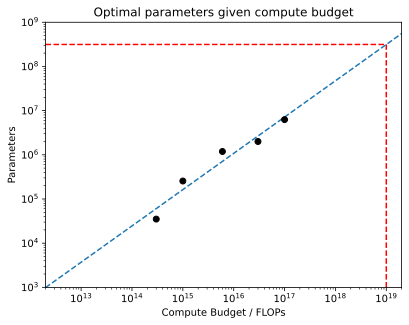

In [282]:
opt_params_o = np.array(opt_params)[2:]
compute_budgets = df['compute_budget'].unique()[2:]
fit_params = curve_fit(lambda x, a, b: a * np.log(x) + b, compute_budgets, np.log(opt_params_o))
a, b = fit_params[0]
# xs = np.linspace(c_min * 0.2, c_max * 5, 200)
xs = np.linspace(c_min * 0.2, 2 * 10.0**24, 200)
ys = a * np.log(xs) + b

print(f"{a=} {b=}")

plt.plot(xs, np.exp(ys), label=f'Fit: {np.exp(b):.2f} * x^{np.exp(a):.2f}', linestyle='--', zorder=1)
plt.scatter(compute_budgets, opt_params_o, c='black')
plt.xscale('log')
plt.yscale('log')
plt.title('Optimal parameters given compute budget')
plt.xlabel('Compute Budget / FLOPs')
plt.ylabel('Parameters')

ext_compute = np.array([10.0**19])
ext_projected = np.exp(a * np.log(ext_compute) + b)
print(ext_compute, ext_projected)
plt.vlines(ext_compute, np.exp(ys).min(), ext_projected, linestyle='--', color='red', zorder=0)
plt.hlines(ext_projected, xs.min(), ext_compute, linestyle='--', color='red', zorder=0)
plt.xlim(xs.min(), ext_compute.max() * 2)
plt.ylim(np.exp(ys).min(), 1e9)

[1.e+19] [5.30959715e+09]


(100000000.0, 7000000000.0)

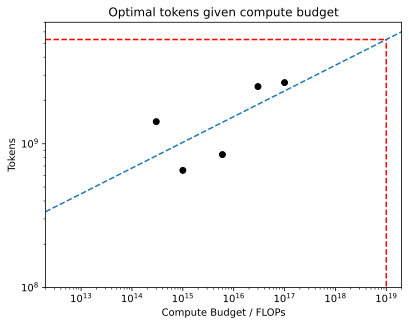

In [283]:
plt.scatter(compute_budgets, compute_budgets / (6 * opt_params_o), c='black')
ys_tok = xs / (6 * np.exp(ys))
plt.plot(xs, ys_tok, label='6 * flops / exp(ys)', linestyle='--', zorder=-5)
plt.xscale('log')
plt.yscale('log')
plt.title('Optimal tokens given compute budget')
plt.xlabel('Compute Budget / FLOPs')
plt.ylabel('Tokens')
ext_projected_tok = ext_compute / (6 * np.exp(a * np.log(ext_compute) + b))
print(ext_compute, ext_projected_tok)
plt.vlines(ext_compute, np.exp(ys).min(), ext_projected_tok, linestyle='--', color='red', zorder=0)
plt.hlines(ext_projected_tok, xs.min(), ext_compute, linestyle='--', color='red', zorder=0)
plt.xlim(xs.min(), ext_compute.max() * 2)
plt.ylim(1e8, 7e9)